In [0]:
%matplotlib inline

In [2]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Common/')

#Importing

In [5]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip
from gradCAM import *
from lr_finder import *

  pip install torch-lr-finder -v --global-option="amp"


#Few Train Images After Transform

CUDA Available? True
Files already downloaded and verified


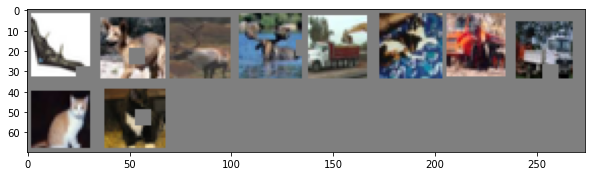

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 512
EPOCHS = 24
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
train_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                              PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT, value=0), 
                              RandomCrop(32, 32),
                              Cutout(num_holes=1, max_h_size=8, max_w_size=8),
                              HorizontalFlip()
                                ]
train_data_transfomrs = getAlbumTransformation(train_data_transforms_list)
trainloader = getTrainDataLoader("CIFAR", dataloader_args, train_data_transfomrs)
showFewDataSetImages(trainloader, 10)




#Model

In [7]:
test_data_transforms_list = [Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
test_data_transfomrs = getAlbumTransformation(test_data_transforms_list)
testloader = getTestDataLoader("CIFAR", dataloader_args, test_data_transfomrs)
model = MyResNetS11().to(device)
summary(model, input_size=(3, 32, 32))

Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
    GhostBatchNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
    GhostBatchNorm-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
       BasicBlock-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         294,912
        MaxPool2d-12            [-1, 256, 8, 8]               0
   GhostBatchNorm-13            [-1, 256, 8, 8]             512
 

#Loss Vs Learning Rate

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


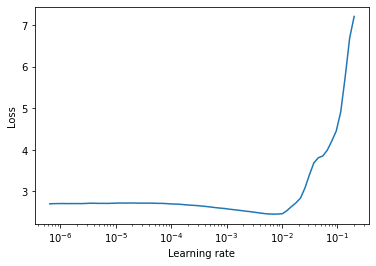

Best LR :  0.007054802310718645
Best Loss :  2.454674719870533


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()
print('Best LR : ', lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)])
print('Best Loss : ',lr_finder.best_loss)

#Accuracy Vs Learning Rate

In [9]:
print(len(trainloader))

98



Learning rate search finished. See the graph with {finder_name}.plot()
Best LR :  0.04656167558653316
Best Acc :  52.34375


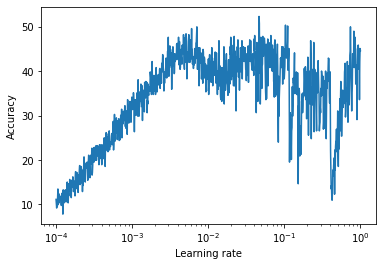

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4)

epoch = 10
stepsPerEpoch = len(trainloader)
iterations = epoch * stepsPerEpoch

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, start_lr=0.0001, end_lr=1, num_iter=iterations, accuracy=True)
print('Best LR : ', lr_finder.history['lr'][lr_finder.history['accuracy'].index(lr_finder.best_acc)])
print('Best Acc : ',lr_finder.best_acc)
lr_finder.plot_acc()
lr_finder.reset()

#Training 

Max LR : 0.046

*   Min LR : 0.046/5 ==> Acc : 91.57
*   Min LR : 0.046/6 ==> Acc : 91.43
*   Min LR : 0.046/7 ==> Acc : 91.59
*   Min LR : 0.046/8 ==> Acc : 92.10
*   Min LR : 0.046/10 ==> Acc : 91.7



In [13]:
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.046
div_factor = 8
min_lr = max_lr/div_factor
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, weight_decay=0.001)
scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=EPOCHS, pct_start=0.2, div_factor=div_factor, final_div_factor=1, anneal_strategy='linear',
                       cycle_momentum=False)
all_train_acc = []

for epoch in range(EPOCHS):
  print('EPOCH : ', epoch, ' LR : ', scheduler.get_lr())
  train(model, device, trainloader, optimizer, criterion, scheduler=scheduler)
  all_train_acc.append(train_acc[-1])
  test.__test(model, device, testloader, criterion)
  

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH :  0  LR :  [0.00575]


Loss=1.4881662130355835 Batch_id=97 Accuracy=41.78: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 5233/10000 (52.33%)

EPOCH :  1  LR :  [0.014153280783979549]


Loss=0.8608748316764832 Batch_id=97 Accuracy=60.61: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6453/10000 (64.53%)

EPOCH :  2  LR :  [0.0225565615679591]


Loss=0.9990553855895996 Batch_id=97 Accuracy=69.16: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 6270/10000 (62.70%)

EPOCH :  3  LR :  [0.030959842351938646]


Loss=0.7715262174606323 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 7153/10000 (71.53%)

EPOCH :  4  LR :  [0.03936312313591819]


Loss=0.5538985133171082 Batch_id=97 Accuracy=77.65: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7387/10000 (73.87%)

EPOCH :  5  LR :  [0.045559337797619046]


Loss=0.6286436915397644 Batch_id=97 Accuracy=79.29: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7998/10000 (79.98%)

EPOCH :  6  LR :  [0.04346298363095238]


Loss=0.409091591835022 Batch_id=97 Accuracy=84.25: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8450/10000 (84.50%)

EPOCH :  7  LR :  [0.041366629464285716]


Loss=0.322890043258667 Batch_id=97 Accuracy=86.37: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8413/10000 (84.13%)

EPOCH :  8  LR :  [0.03927027529761905]


Loss=0.31656336784362793 Batch_id=97 Accuracy=87.74: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8476/10000 (84.76%)

EPOCH :  9  LR :  [0.03717392113095238]


Loss=0.32269981503486633 Batch_id=97 Accuracy=89.49: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8794/10000 (87.94%)

EPOCH :  10  LR :  [0.03507756696428571]


Loss=0.2732863426208496 Batch_id=97 Accuracy=90.90: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8794/10000 (87.94%)

EPOCH :  11  LR :  [0.03298121279761905]


Loss=0.22376815974712372 Batch_id=97 Accuracy=91.71: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8700/10000 (87.00%)

EPOCH :  12  LR :  [0.030884858630952382]


Loss=0.25073978304862976 Batch_id=97 Accuracy=92.46: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8533/10000 (85.33%)

EPOCH :  13  LR :  [0.028788504464285714]


Loss=0.20322731137275696 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8912/10000 (89.12%)

EPOCH :  14  LR :  [0.02669215029761905]


Loss=0.16662919521331787 Batch_id=97 Accuracy=93.93: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8916/10000 (89.16%)

EPOCH :  15  LR :  [0.02459579613095238]


Loss=0.17940840125083923 Batch_id=97 Accuracy=94.71: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8928/10000 (89.28%)

EPOCH :  16  LR :  [0.022499441964285712]


Loss=0.16901139914989471 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9060/10000 (90.60%)

EPOCH :  17  LR :  [0.020403087797619048]


Loss=0.10322526842355728 Batch_id=97 Accuracy=95.78: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9007/10000 (90.07%)

EPOCH :  18  LR :  [0.01830673363095238]


Loss=0.10615076124668121 Batch_id=97 Accuracy=96.51: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9039/10000 (90.39%)

EPOCH :  19  LR :  [0.01621037946428571]


Loss=0.10353825986385345 Batch_id=97 Accuracy=97.09: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9110/10000 (91.10%)

EPOCH :  20  LR :  [0.01411402529761905]


Loss=0.08584129065275192 Batch_id=97 Accuracy=97.43: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8967/10000 (89.67%)

EPOCH :  21  LR :  [0.012017671130952381]


Loss=0.07243567705154419 Batch_id=97 Accuracy=97.89: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9142/10000 (91.42%)

EPOCH :  22  LR :  [0.009921316964285713]


Loss=0.04732832312583923 Batch_id=97 Accuracy=98.38: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9192/10000 (91.92%)

EPOCH :  23  LR :  [0.007824962797619045]


Loss=0.05578616261482239 Batch_id=97 Accuracy=98.51: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]



Test set: Average loss: 0.0005, Accuracy: 9210/10000 (92.10%)



#Saving model

In [14]:

!mkdir savedModels
import torch
modelName = 'cifar_myresnet18'
torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

mkdir: cannot create directory ‘savedModels’: File exists


#Accuracy Plot


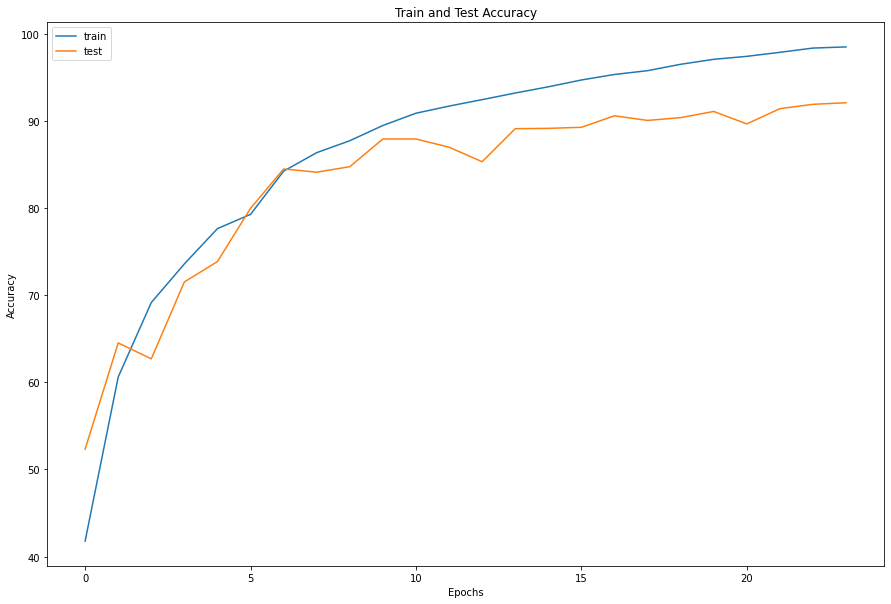

In [15]:
all_test_acc = {'train':all_train_acc,'test':test.test_acc}
plotGraph(all_test_acc, "Train and Test Accuracy","Epochs", "Accuracy")

#Misclassified Images

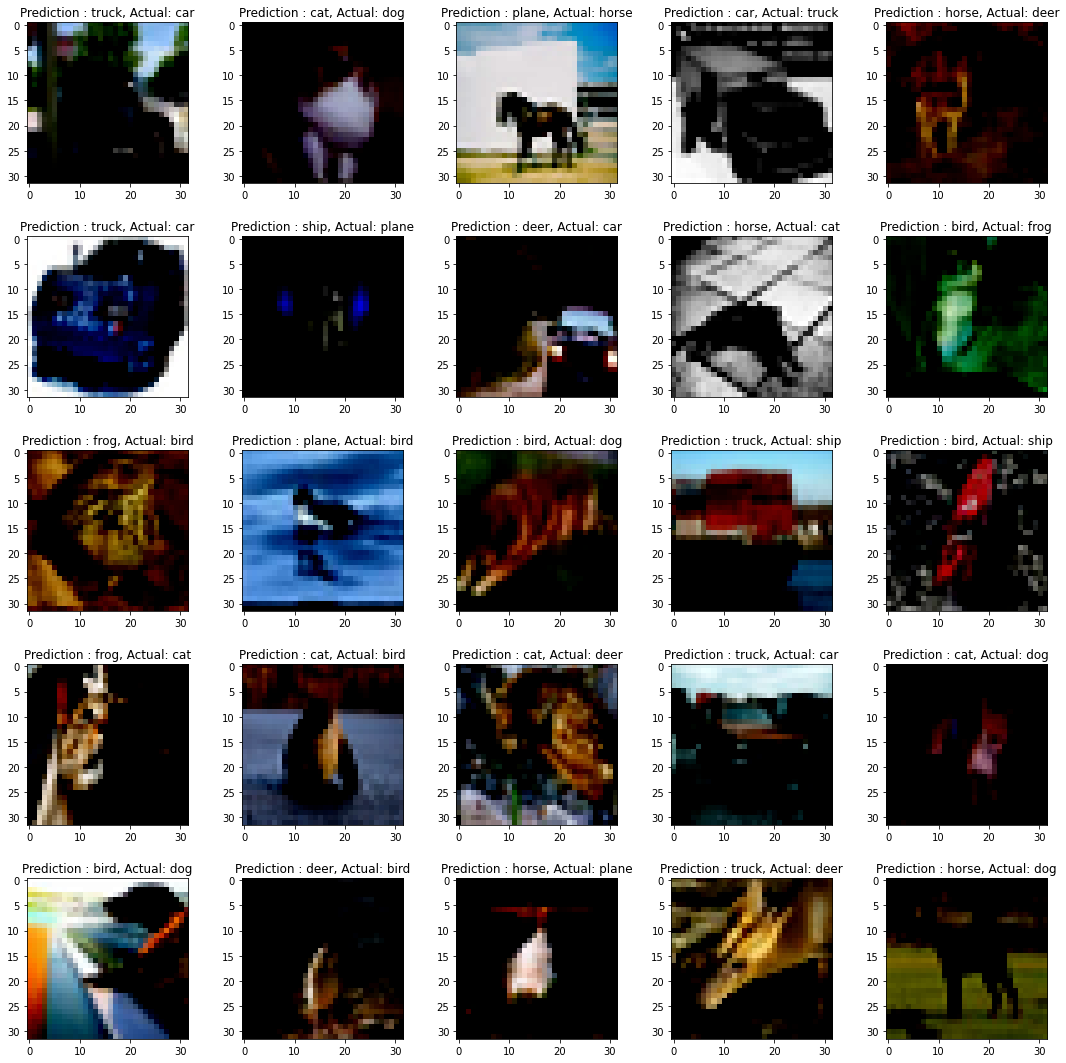

In [16]:
missClassImgs = getMisclassifiedImages(MyResNetS11(), testloader, device, 'savedModels/'+modelName+'.pt')
plotMisclassifiedImages(missClassImgs, classes)

#GradCam

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


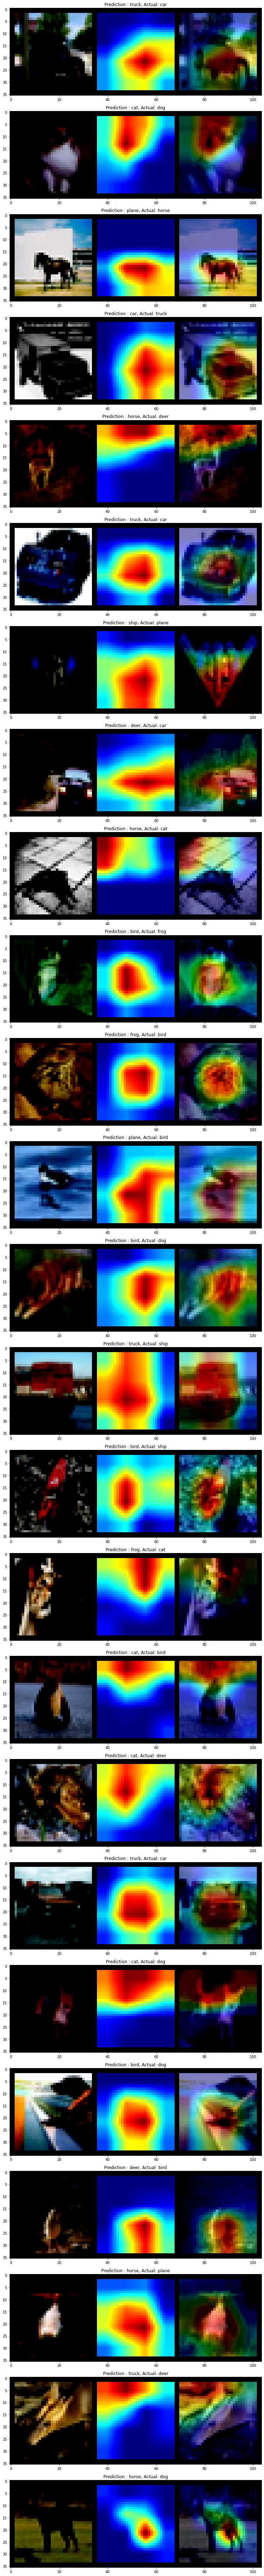

In [17]:
titles = getPredActualTitle(missClassImgs[:25], classes)
getGradCamOutput(MyResNetS11(), 'resnet', 'savedModels/'+modelName+'.pt', 'res2', missClassImgs[:25], titles)